# Correcting both bit-flip and phase-flip errors

This notebook implements the quantum circuit to recover a qubit from both bit flip and phase flip errors, using Shor's 9-quibts encoding.

## Importing needed modules

In [51]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer

## Three qubit encoding

Because of the no cloning theorem we cannot copy a qubit to add redundancy like we would do in classical computing. What we can do instead is implementing the following encoding:<br><br>
<center>
$|\psi\rangle =  \alpha|0\rangle + \beta|1\rangle \rightarrow \frac{\alpha}{\sqrt{8}}(|000\rangle + |111\rangle)^\otimes 3 + \frac{\beta}{\sqrt{8}}(|000\rangle - |111\rangle)^\otimes 3$
</center>


## Inizializing the circuit

For the circuit we need three qubits for the econding and two auxiliary qubits that will be used to detect if the bit flip occured and in which qubit.

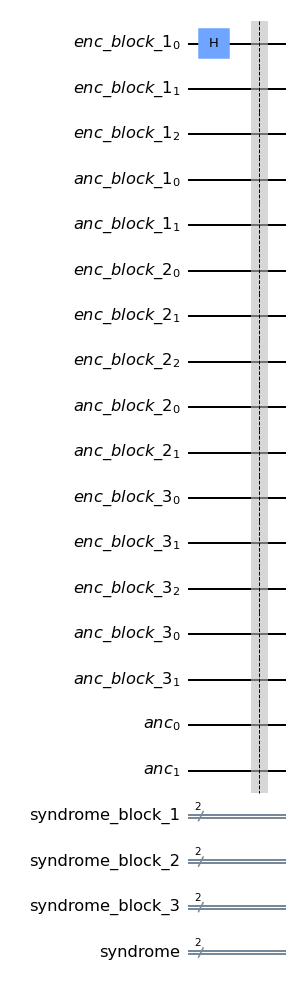

In [59]:
q_enc_b1 = QuantumRegister(3, "enc_block_1")
q_anc_b1 = QuantumRegister(2, "anc_block_1")
c_syn_b1 = ClassicalRegister(2, "syndrome_block_1")

q_enc_b2 = QuantumRegister(3, "enc_block_2")
q_anc_b2 = QuantumRegister(2, "anc_block_2")
c_syn_b2 = ClassicalRegister(2, "syndrome_block_2")

q_enc_b3 = QuantumRegister(3, "enc_block_3")
q_anc_b3 = QuantumRegister(2, "anc_block_3")
c_syn_b3 = ClassicalRegister(2, "syndrome_block_3")

q_anc = QuantumRegister(2, "anc")
c_syn = ClassicalRegister(2, "syndrome")

qc = QuantumCircuit()

for reg in [q_enc_b1, q_anc_b1, c_syn_b1, q_enc_b2, q_anc_b2, c_syn_b2, q_enc_b3, q_anc_b3, c_syn_b3, q_anc, c_syn]:
    qc.add_register(reg)
    
qc.h(q_enc_b1[0])
    
qc.barrier()
qc.draw(output="mpl")

## Implementing the encoding


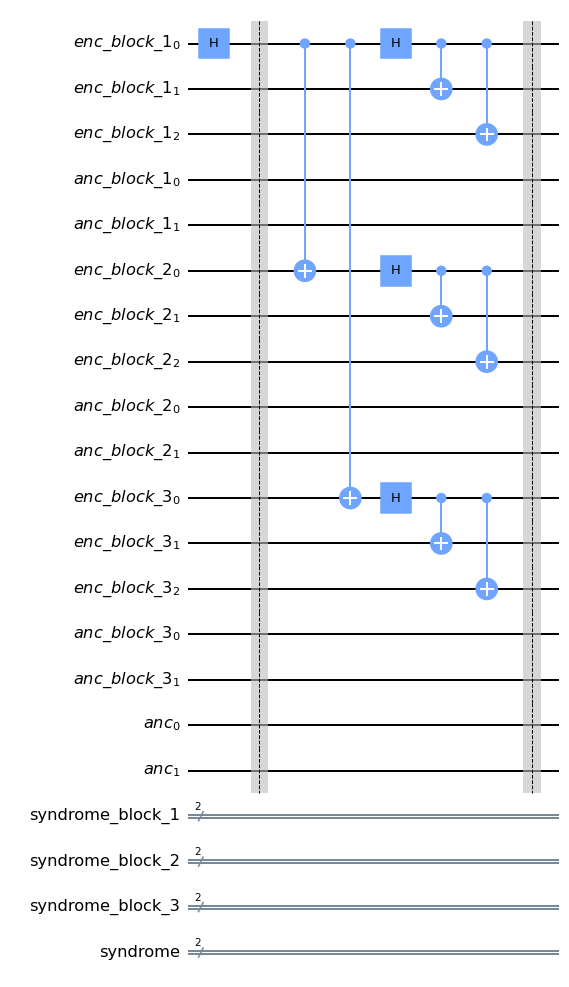

In [60]:
# we apply the phase flip encoding using the first qubit of each block
qc.cx(q_enc_b1[0], q_enc_b2[0])
qc.cx(q_enc_b1[0], q_enc_b3[0])
qc.h(q_enc_b1[0])
qc.h(q_enc_b2[0])
qc.h(q_enc_b3[0])

# we apply the bit flip encoding to the thee qubit of each block
qc.cx(q_enc_b1[0], q_enc_b1[1])
qc.cx(q_enc_b1[0], q_enc_b1[2])

qc.cx(q_enc_b2[0], q_enc_b2[1])
qc.cx(q_enc_b2[0], q_enc_b2[2])

qc.cx(q_enc_b3[0], q_enc_b3[1])
qc.cx(q_enc_b3[0], q_enc_b3[2])


qc.barrier()

qc.draw(output="mpl")

## Simulate the error

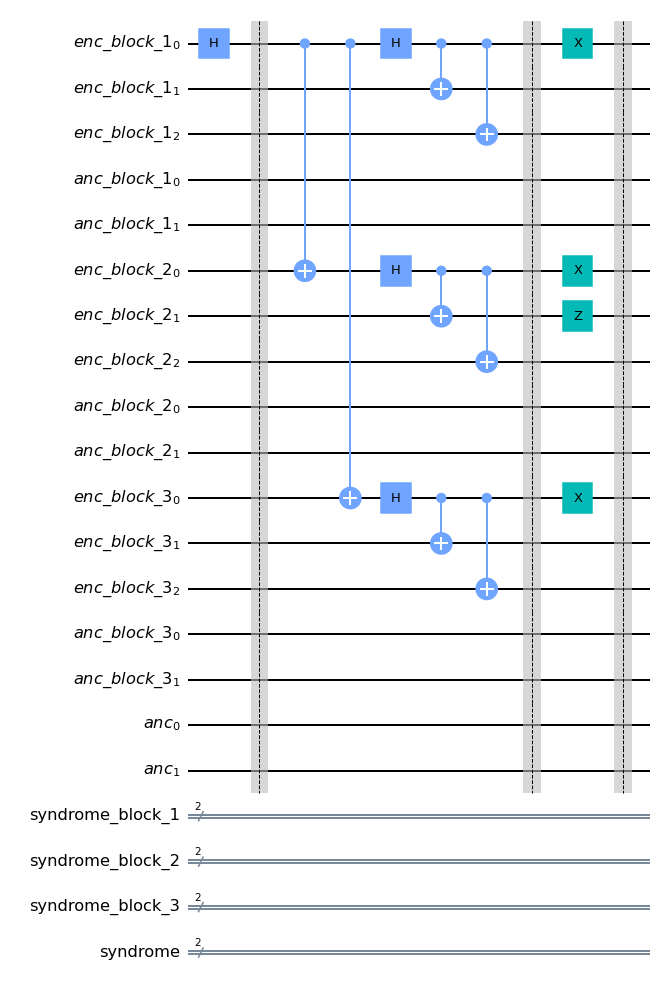

In [61]:
qc.x(q_enc_b1[0])
qc.x(q_enc_b2[0])
qc.x(q_enc_b3[0])
qc.z(q_enc_b2[1])

qc.barrier()


## Add the circuit for the bit flip correction to each group of qubits

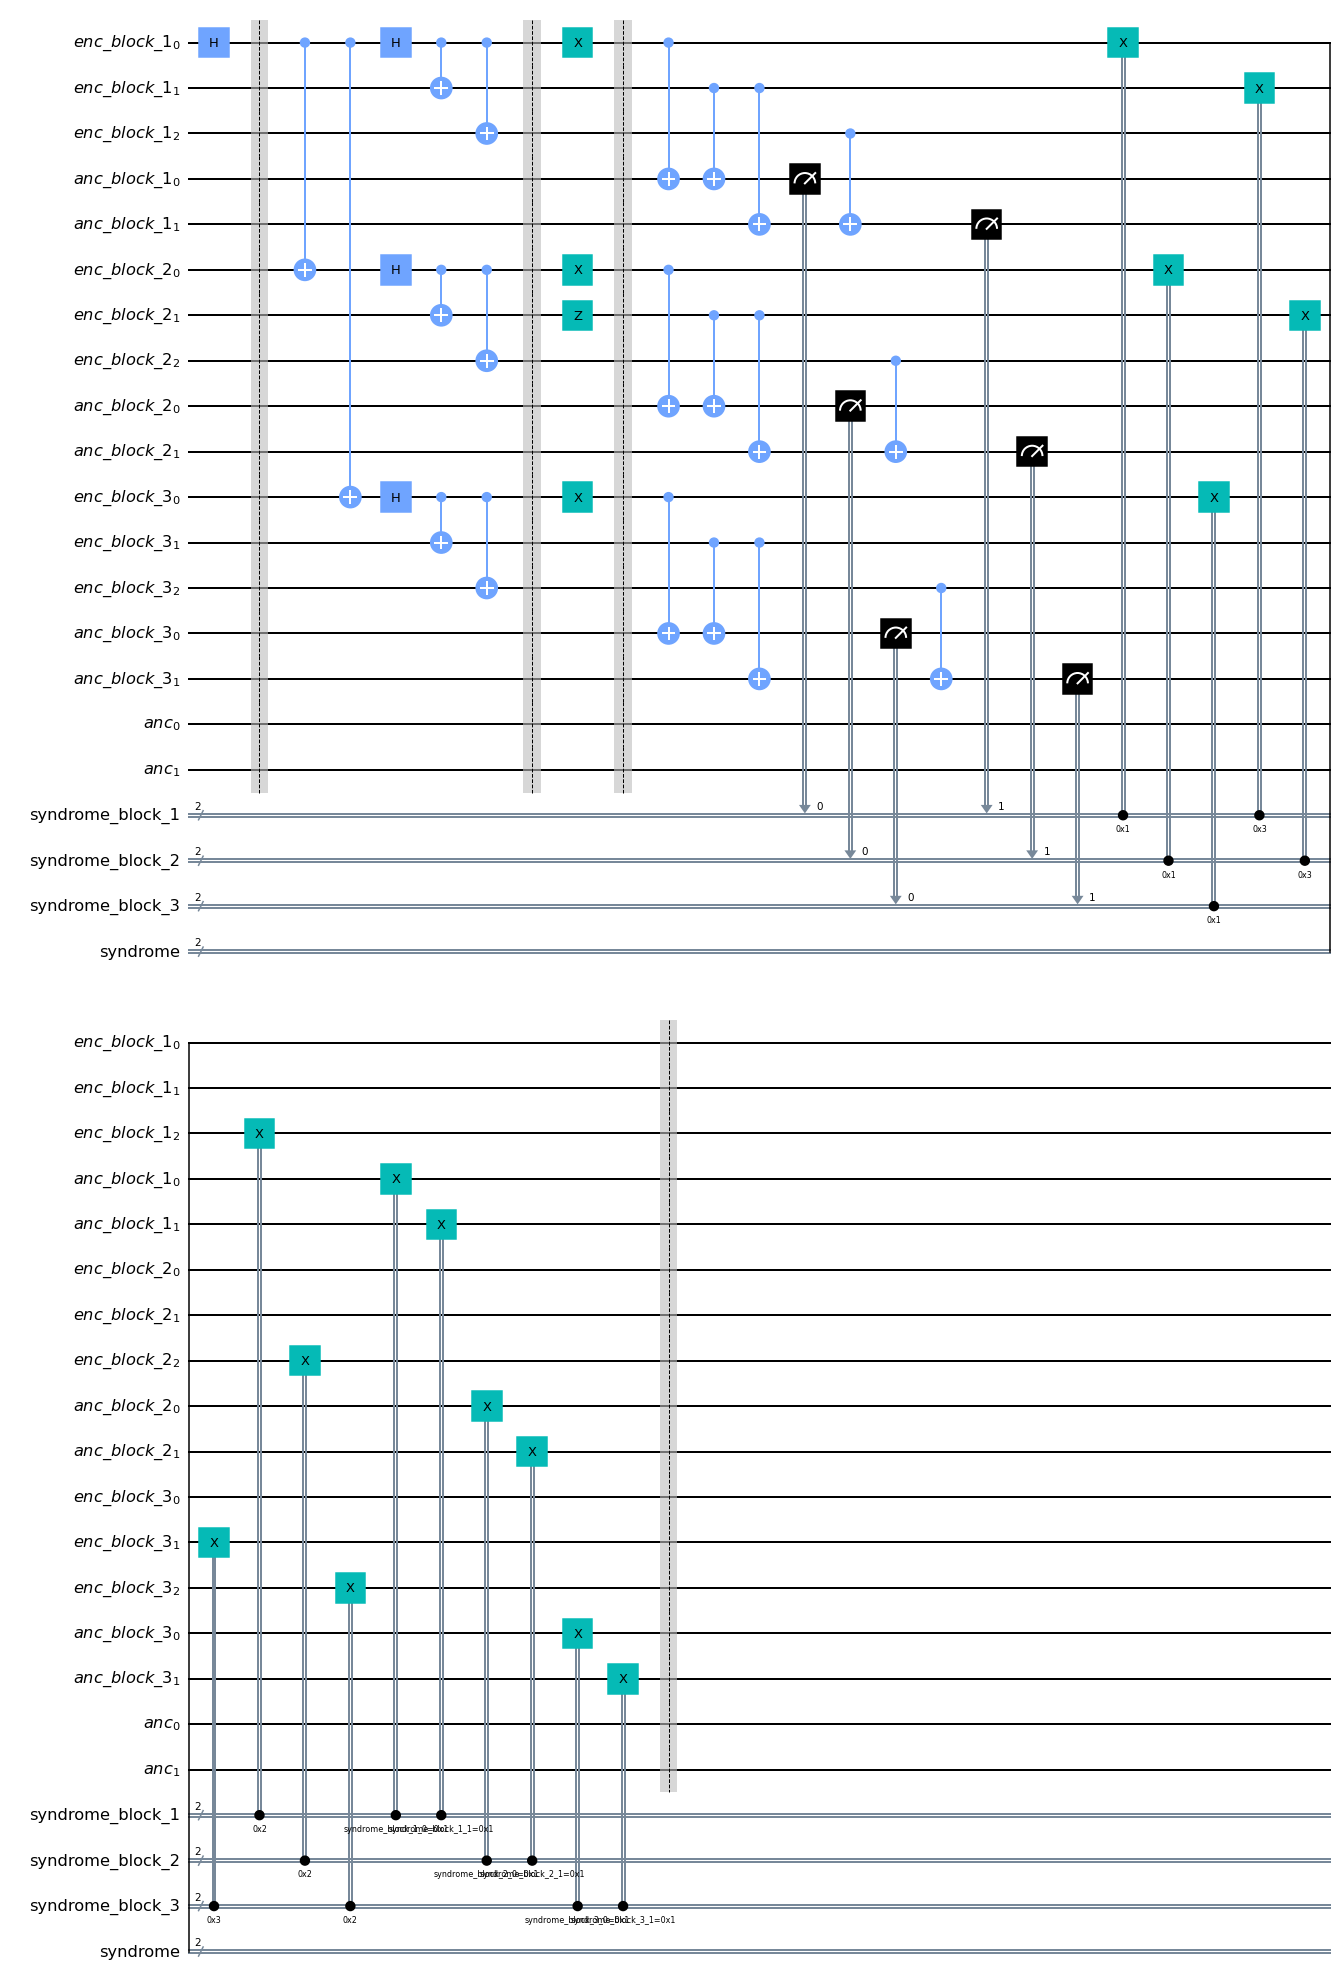

In [62]:
# first block
qc.cx(q_enc_b1[0], q_anc_b1[0])
qc.cx(q_enc_b1[1], q_anc_b1[0])
qc.cx(q_enc_b1[1], q_anc_b1[1])
qc.cx(q_enc_b1[2], q_anc_b1[1])

qc.measure(q_anc_b1[0], c_syn_b1[0])
qc.measure(q_anc_b1[1], c_syn_b1[1])

qc.x(q_enc_b1[0]).c_if(c_syn_b1, 1)
qc.x(q_enc_b1[1]).c_if(c_syn_b1, 3)
qc.x(q_enc_b1[2]).c_if(c_syn_b1, 2)

qc.x(q_anc_b1[0]).c_if(c_syn_b1[0], 1)
qc.x(q_anc_b1[1]).c_if(c_syn_b1[1], 1)

# second block
qc.cx(q_enc_b2[0], q_anc_b2[0])
qc.cx(q_enc_b2[1], q_anc_b2[0])
qc.cx(q_enc_b2[1], q_anc_b2[1])
qc.cx(q_enc_b2[2], q_anc_b2[1])

qc.measure(q_anc_b2[0], c_syn_b2[0])
qc.measure(q_anc_b2[1], c_syn_b2[1])

qc.x(q_enc_b2[0]).c_if(c_syn_b2, 1)
qc.x(q_enc_b2[1]).c_if(c_syn_b2, 3)
qc.x(q_enc_b2[2]).c_if(c_syn_b2, 2)

qc.x(q_anc_b2[0]).c_if(c_syn_b2[0], 1)
qc.x(q_anc_b2[1]).c_if(c_syn_b2[1], 1)


# third block
qc.cx(q_enc_b3[0], q_anc_b3[0])
qc.cx(q_enc_b3[1], q_anc_b3[0])
qc.cx(q_enc_b3[1], q_anc_b3[1])
qc.cx(q_enc_b3[2], q_anc_b3[1])

qc.measure(q_anc_b3[0], c_syn_b3[0])
qc.measure(q_anc_b3[1], c_syn_b3[1])

qc.x(q_enc_b3[0]).c_if(c_syn_b3, 1)
qc.x(q_enc_b3[1]).c_if(c_syn_b3, 3)
qc.x(q_enc_b3[2]).c_if(c_syn_b3, 2)

qc.x(q_anc_b3[0]).c_if(c_syn_b3[0], 1)
qc.x(q_anc_b3[1]).c_if(c_syn_b3[1], 1)

qc.barrier()
qc.draw("mpl")

## Add the circuit for the phase flip correction among the groups of bits

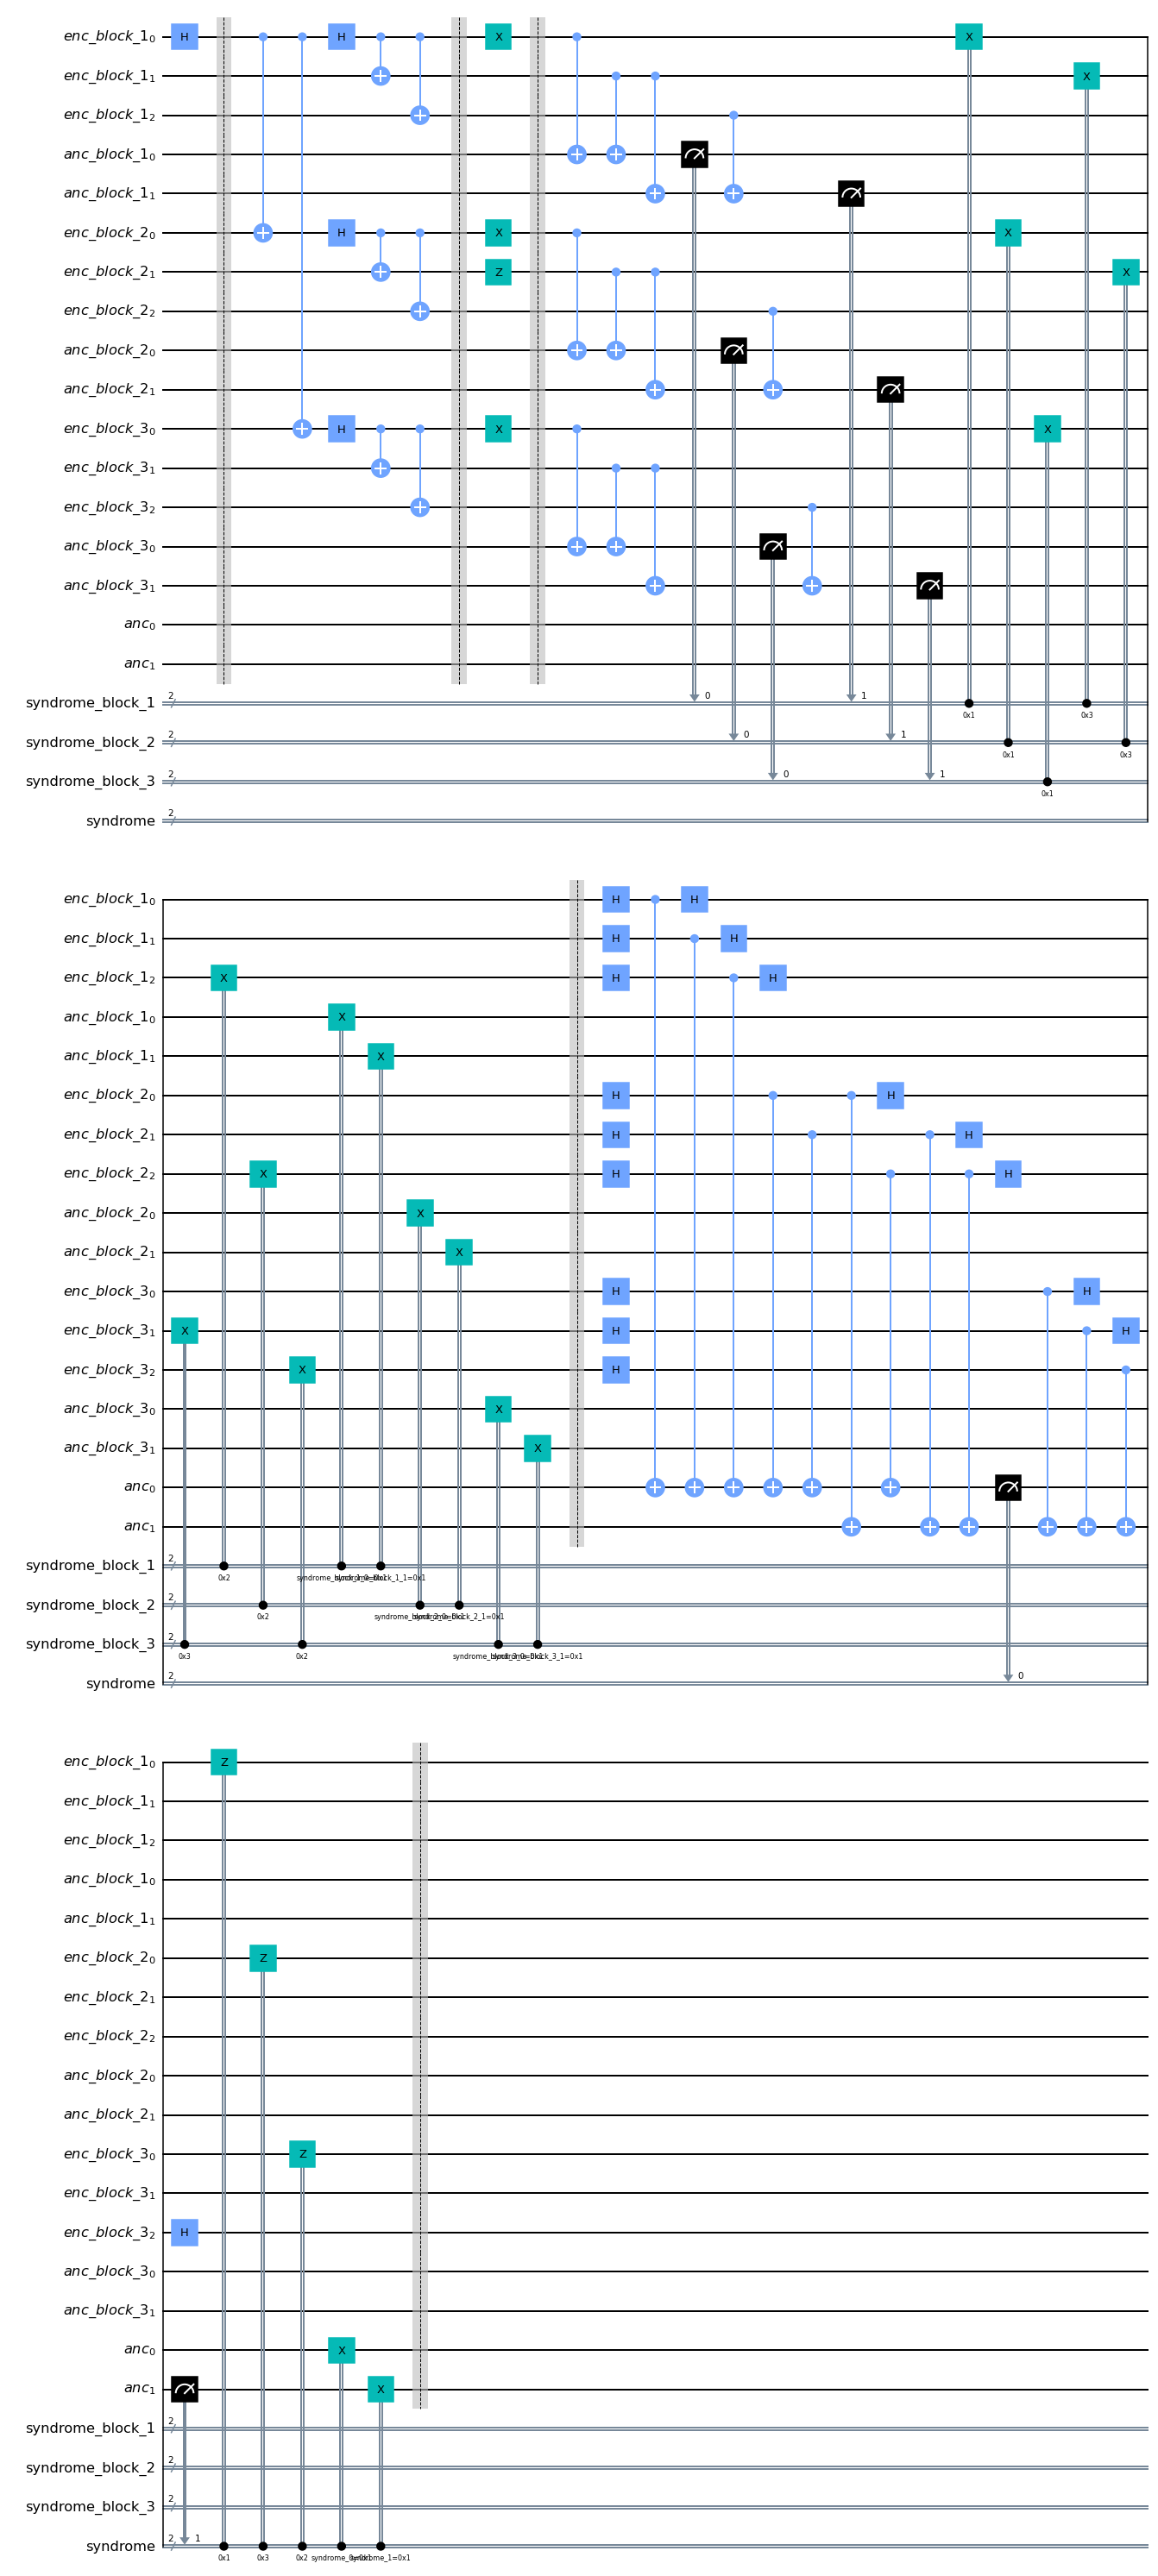

In [63]:
qc.h(q_enc_b1[0])
qc.h(q_enc_b1[1])
qc.h(q_enc_b1[2])
qc.h(q_enc_b2[0])
qc.h(q_enc_b2[1])
qc.h(q_enc_b2[2])
qc.h(q_enc_b3[0])
qc.h(q_enc_b3[1])
qc.h(q_enc_b3[2])

qc.cx(q_enc_b1[0], q_anc[0])
qc.cx(q_enc_b1[1], q_anc[0])
qc.cx(q_enc_b1[2], q_anc[0])

qc.cx(q_enc_b2[0], q_anc[0])
qc.cx(q_enc_b2[1], q_anc[0])
qc.cx(q_enc_b2[2], q_anc[0])

qc.cx(q_enc_b2[0], q_anc[1])
qc.cx(q_enc_b2[1], q_anc[1])
qc.cx(q_enc_b2[2], q_anc[1])

qc.cx(q_enc_b3[0], q_anc[1])
qc.cx(q_enc_b3[1], q_anc[1])
qc.cx(q_enc_b3[2], q_anc[1])

qc.h(q_enc_b1[0])
qc.h(q_enc_b1[1])
qc.h(q_enc_b1[2])
qc.h(q_enc_b2[0])
qc.h(q_enc_b2[1])
qc.h(q_enc_b2[2])
qc.h(q_enc_b3[0])
qc.h(q_enc_b3[1])
qc.h(q_enc_b3[2])

qc.measure(q_anc[0], c_syn[0])
qc.measure(q_anc[1], c_syn[1])

qc.z(q_enc_b1[0]).c_if(c_syn, 1)
qc.z(q_enc_b2[0]).c_if(c_syn, 3)
qc.z(q_enc_b3[0]).c_if(c_syn, 2)

qc.x(q_anc[0]).c_if(c_syn[0], 1)
qc.x(q_anc[1]).c_if(c_syn[1], 1)


qc.barrier()
qc.draw("mpl")

## Decoding

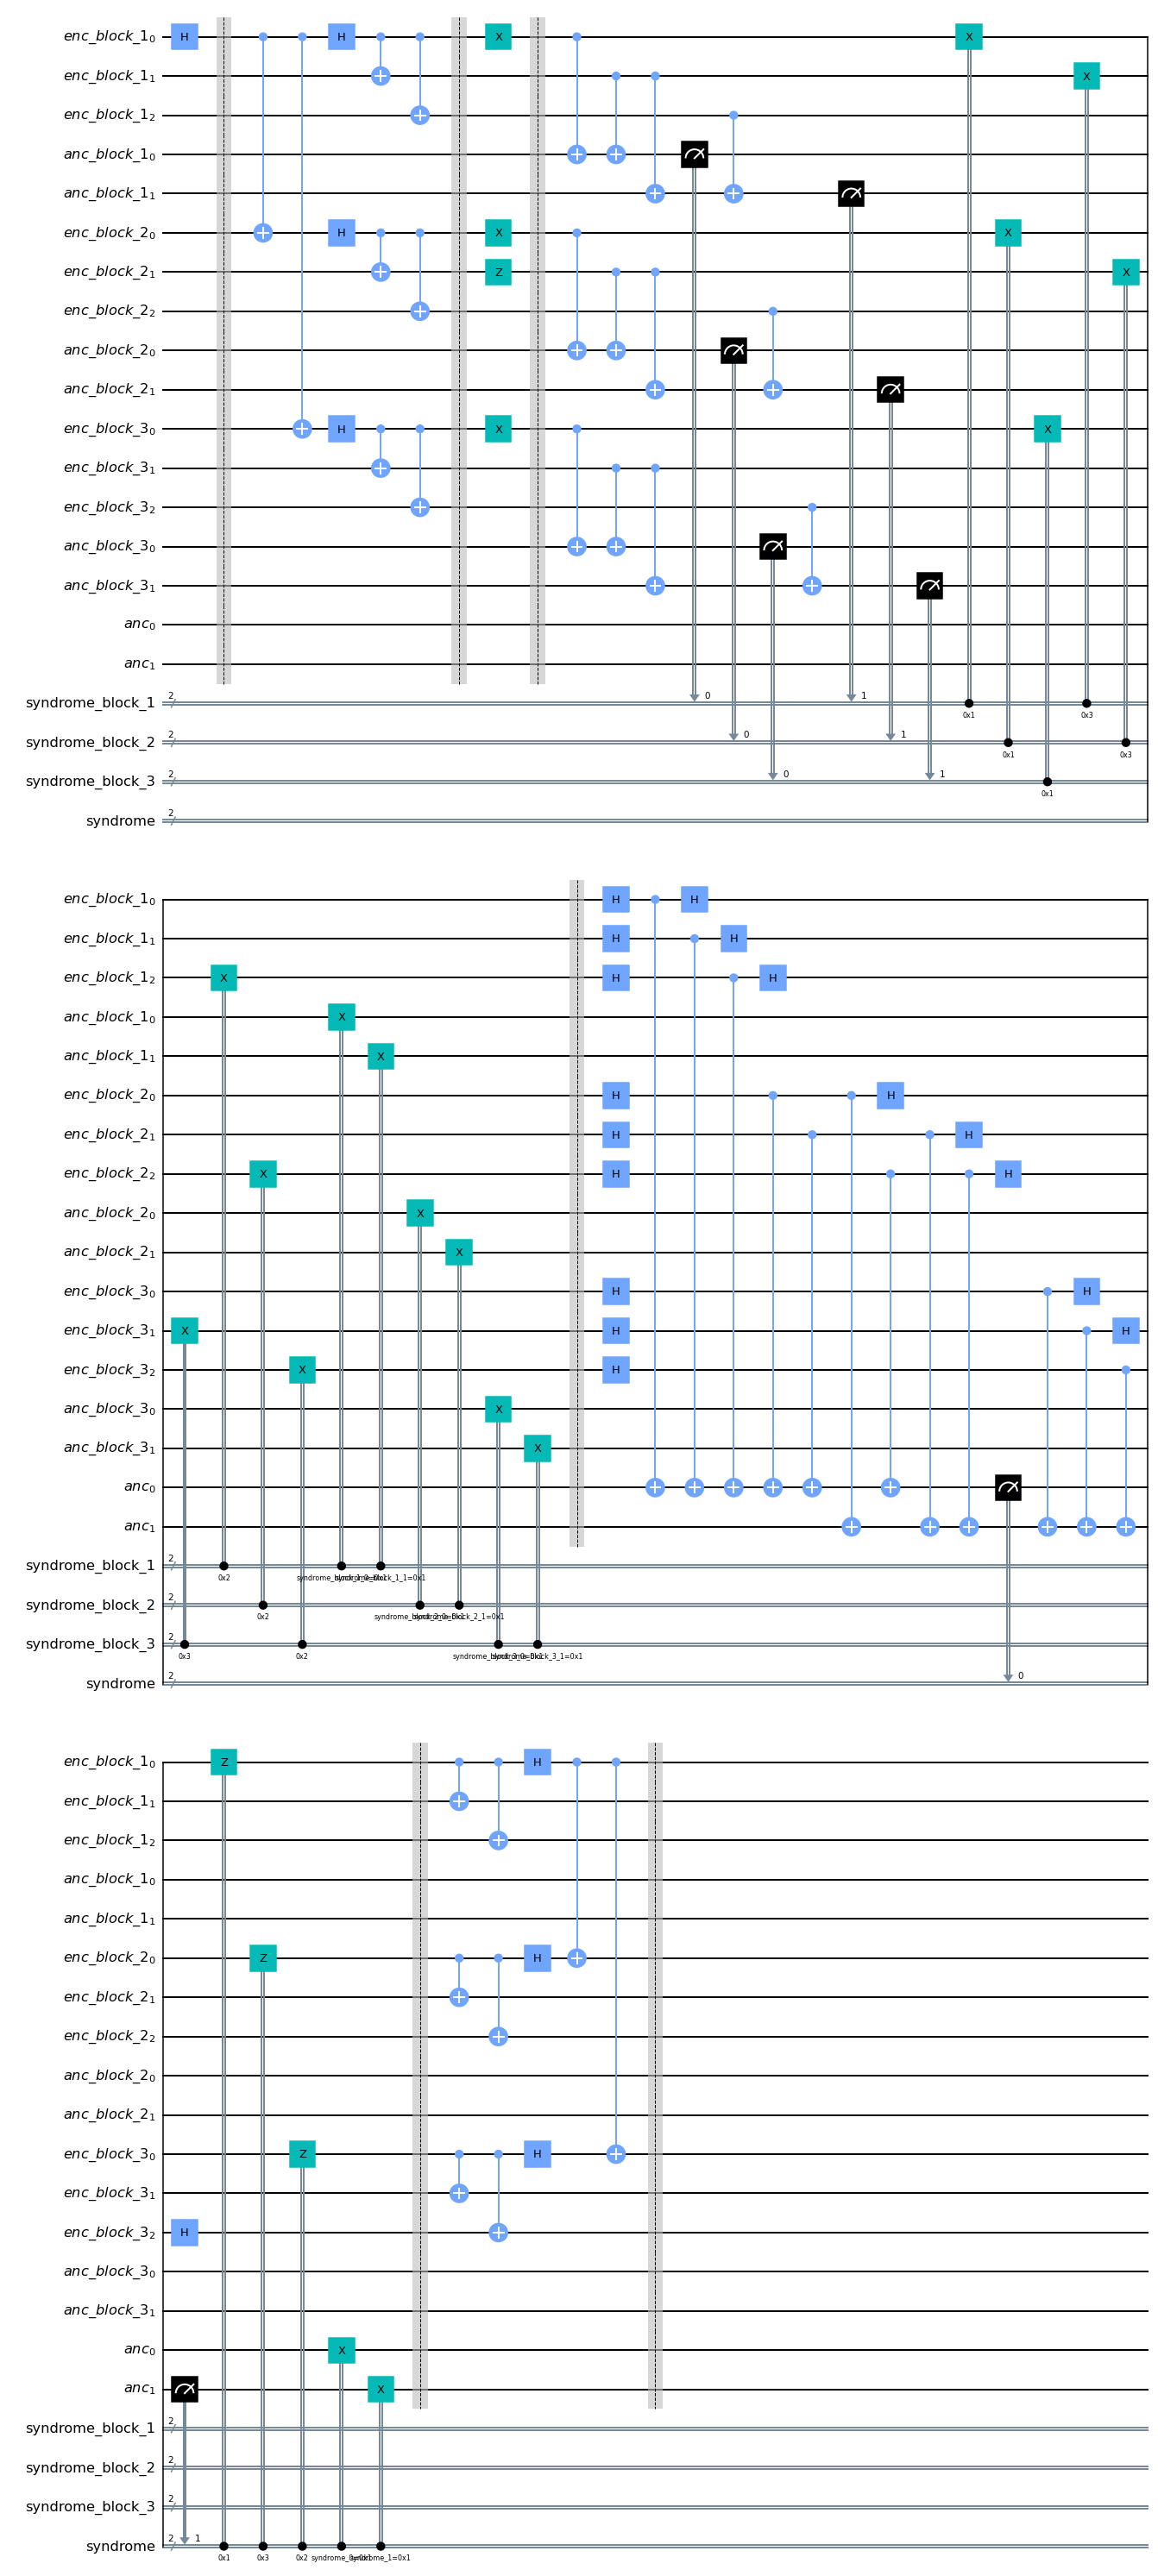

In [64]:
qc.cx(q_enc_b1[0], q_enc_b1[1])
qc.cx(q_enc_b1[0], q_enc_b1[2])

qc.cx(q_enc_b2[0], q_enc_b2[1])
qc.cx(q_enc_b2[0], q_enc_b2[2])

qc.cx(q_enc_b3[0], q_enc_b3[1])
qc.cx(q_enc_b3[0], q_enc_b3[2])


qc.h(q_enc_b1[0])
qc.h(q_enc_b2[0])
qc.h(q_enc_b3[0])

qc.cx(q_enc_b1[0], q_enc_b2[0])
qc.cx(q_enc_b1[0], q_enc_b3[0])




qc.draw(output="mpl")

## Executing the circuit

In [67]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(qc)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
alpha = outputstate[0]
beta = outputstate[1]

simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=1000)
syndrome = job.result().get_counts(qc)
print(f"Syndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"Decoded state:\n{alpha}|0> + {beta}|1>")

Syndrome qubits: 10 10 10 11
Decoded state:
(0.707-0j)|0> + (0.707-0j)|1>


## Defining test function

In [71]:
def circuit(input_state, bit_error_mask, phase_error_mask):
    
    # initializing the circuit
    
    q_enc_b1 = QuantumRegister(3, "enc_block_1")
    q_anc_b1 = QuantumRegister(2, "anc_block_1")
    c_syn_b1 = ClassicalRegister(2, "syndrome_block_1")

    q_enc_b2 = QuantumRegister(3, "enc_block_2")
    q_anc_b2 = QuantumRegister(2, "anc_block_2")
    c_syn_b2 = ClassicalRegister(2, "syndrome_block_2")

    q_enc_b3 = QuantumRegister(3, "enc_block_3")
    q_anc_b3 = QuantumRegister(2, "anc_block_3")
    c_syn_b3 = ClassicalRegister(2, "syndrome_block_3")

    q_anc = QuantumRegister(2, "anc")
    c_syn = ClassicalRegister(2, "syndrome")

    qc = QuantumCircuit()

    for reg in [q_enc_b1, q_anc_b1, c_syn_b1, q_enc_b2, q_anc_b2, c_syn_b2, q_enc_b3, q_anc_b3, c_syn_b3, q_anc, c_syn]:
        qc.add_register(reg)

    qc.h(q_enc_b1[0])

    qc.barrier()
    
    # encoding
    
    # we apply the phase flip encoding using the first qubit of each block
    qc.cx(q_enc_b1[0], q_enc_b2[0])
    qc.cx(q_enc_b1[0], q_enc_b3[0])
    qc.h(q_enc_b1[0])
    qc.h(q_enc_b2[0])
    qc.h(q_enc_b3[0])

    # we apply the bit flip encoding to the thee qubit of each block
    qc.cx(q_enc_b1[0], q_enc_b1[1])
    qc.cx(q_enc_b1[0], q_enc_b1[2])

    qc.cx(q_enc_b2[0], q_enc_b2[1])
    qc.cx(q_enc_b2[0], q_enc_b2[2])

    qc.cx(q_enc_b3[0], q_enc_b3[1])
    qc.cx(q_enc_b3[0], q_enc_b3[2])

    qc.barrier()
    
    # simulate the error
    
    print(bit_error_mask)
    
    for i in range(len(bit_error_mask[:3])):
        if bit_error_mask[i] == 1:
            qc.x(q_enc_b1[i])
            
    for i in range(len(bit_error_mask[:3])):
        if bit_error_mask[i] == 1:
            qc.x(q_enc_b2[i])
            
    for i in range(len(bit_error_mask[:3])):
        if bit_error_mask[i] == 1:
            qc.x(q_enc_b3[i])
            
    for i in range(len(phase_error_mask[:3])):
        if phase_error_mask[i] == 1:
            qc.z(q_enc_b1[i])
            
    for i in range(len(phase_error_mask[:3])):
        if phase_error_mask[i] == 1:
            qc.z(q_enc_b2[i])
            
    for i in range(len(phase_error_mask[:3])):
        if phase_error_mask[i] == 1:
            qc.z(q_enc_b3[i])
    
    qc.x(q_enc_b1[0])
    qc.x(q_enc_b2[0])
    qc.x(q_enc_b3[0])
    qc.z(q_enc_b2[1])
    
    qc.barrier()
    
    # bit flip correction
    
    # first block
    qc.cx(q_enc_b1[0], q_anc_b1[0])
    qc.cx(q_enc_b1[1], q_anc_b1[0])
    qc.cx(q_enc_b1[1], q_anc_b1[1])
    qc.cx(q_enc_b1[2], q_anc_b1[1])

    qc.measure(q_anc_b1[0], c_syn_b1[0])
    qc.measure(q_anc_b1[1], c_syn_b1[1])

    qc.x(q_enc_b1[0]).c_if(c_syn_b1, 1)
    qc.x(q_enc_b1[1]).c_if(c_syn_b1, 3)
    qc.x(q_enc_b1[2]).c_if(c_syn_b1, 2)

    qc.x(q_anc_b1[0]).c_if(c_syn_b1[0], 1)
    qc.x(q_anc_b1[1]).c_if(c_syn_b1[1], 1)

    # second block
    qc.cx(q_enc_b2[0], q_anc_b2[0])
    qc.cx(q_enc_b2[1], q_anc_b2[0])
    qc.cx(q_enc_b2[1], q_anc_b2[1])
    qc.cx(q_enc_b2[2], q_anc_b2[1])

    qc.measure(q_anc_b2[0], c_syn_b2[0])
    qc.measure(q_anc_b2[1], c_syn_b2[1])

    qc.x(q_enc_b2[0]).c_if(c_syn_b2, 1)
    qc.x(q_enc_b2[1]).c_if(c_syn_b2, 3)
    qc.x(q_enc_b2[2]).c_if(c_syn_b2, 2)

    qc.x(q_anc_b2[0]).c_if(c_syn_b2[0], 1)
    qc.x(q_anc_b2[1]).c_if(c_syn_b2[1], 1)


    # third block
    qc.cx(q_enc_b3[0], q_anc_b3[0])
    qc.cx(q_enc_b3[1], q_anc_b3[0])
    qc.cx(q_enc_b3[1], q_anc_b3[1])
    qc.cx(q_enc_b3[2], q_anc_b3[1])

    qc.measure(q_anc_b3[0], c_syn_b3[0])
    qc.measure(q_anc_b3[1], c_syn_b3[1])

    qc.x(q_enc_b3[0]).c_if(c_syn_b3, 1)
    qc.x(q_enc_b3[1]).c_if(c_syn_b3, 3)
    qc.x(q_enc_b3[2]).c_if(c_syn_b3, 2)

    qc.x(q_anc_b3[0]).c_if(c_syn_b3[0], 1)
    qc.x(q_anc_b3[1]).c_if(c_syn_b3[1], 1)

    qc.barrier()
    
    # phase flip correction
    
    qc.h(q_enc_b1[0])
    qc.h(q_enc_b1[1])
    qc.h(q_enc_b1[2])
    qc.h(q_enc_b2[0])
    qc.h(q_enc_b2[1])
    qc.h(q_enc_b2[2])
    qc.h(q_enc_b3[0])
    qc.h(q_enc_b3[1])
    qc.h(q_enc_b3[2])

    qc.cx(q_enc_b1[0], q_anc[0])
    qc.cx(q_enc_b1[1], q_anc[0])
    qc.cx(q_enc_b1[2], q_anc[0])

    qc.cx(q_enc_b2[0], q_anc[0])
    qc.cx(q_enc_b2[1], q_anc[0])
    qc.cx(q_enc_b2[2], q_anc[0])

    qc.cx(q_enc_b2[0], q_anc[1])
    qc.cx(q_enc_b2[1], q_anc[1])
    qc.cx(q_enc_b2[2], q_anc[1])

    qc.cx(q_enc_b3[0], q_anc[1])
    qc.cx(q_enc_b3[1], q_anc[1])
    qc.cx(q_enc_b3[2], q_anc[1])

    qc.h(q_enc_b1[0])
    qc.h(q_enc_b1[1])
    qc.h(q_enc_b1[2])
    qc.h(q_enc_b2[0])
    qc.h(q_enc_b2[1])
    qc.h(q_enc_b2[2])
    qc.h(q_enc_b3[0])
    qc.h(q_enc_b3[1])
    qc.h(q_enc_b3[2])

    qc.measure(q_anc[0], c_syn[0])
    qc.measure(q_anc[1], c_syn[1])

    qc.z(q_enc_b1[0]).c_if(c_syn, 1)
    qc.z(q_enc_b2[0]).c_if(c_syn, 3)
    qc.z(q_enc_b3[0]).c_if(c_syn, 2)

    qc.x(q_anc[0]).c_if(c_syn[0], 1)
    qc.x(q_anc[1]).c_if(c_syn[1], 1)

    qc.barrier()
    
    # decoding
    
    qc.cx(q_enc_b1[0], q_enc_b1[1])
    qc.cx(q_enc_b1[0], q_enc_b1[2])

    qc.cx(q_enc_b2[0], q_enc_b2[1])
    qc.cx(q_enc_b2[0], q_enc_b2[2])

    qc.cx(q_enc_b3[0], q_enc_b3[1])
    qc.cx(q_enc_b3[0], q_enc_b3[2])


    qc.h(q_enc_b1[0])
    qc.h(q_enc_b2[0])
    qc.h(q_enc_b3[0])

    qc.cx(q_enc_b1[0], q_enc_b2[0])
    qc.cx(q_enc_b1[0], q_enc_b3[0])
    
    backend = Aer.get_backend('statevector_simulator')
    job = backend.run(qc)
    result = job.result()
    outputstate = result.get_statevector(qc, decimals=3)
    alpha = outputstate[0]
    beta = outputstate[1]

    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, simulator, shots=1000)
    syndrome = job.result().get_counts(qc)
    
    return alpha, beta, syndrome, qc


In [72]:
alpha, beta, syndrome, qc = circuit(0, (1,0,0,1,0,0,1,0,0), (0,0,0,0,0,0,0,0,0))
print(f"Syndrome qubits: {list(syndrome.keys())[0][::-1]}")
print(f"Decoded state:\n{alpha}|0> + {beta}|1>")
qc.draw()

(1, 0, 0, 1, 0, 0, 1, 0, 0)


TypeError: 'int' object is not iterable